In [9]:
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/6289/hw4/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Load the dataset
def load_data():
  (x_train, y_train), (_, _) = mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5)/127.5
  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train)

X_train, y_train = load_data()
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


In [11]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(units=256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=1024))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=784, activation='tanh'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model

generator = build_generator()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 784)              

In [12]:
def build_discriminator():
    model = Sequential()
    
    model.add(Dense(units=1024 ,input_dim=784))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
      
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model
  
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)              

In [13]:
def build_GAN(discriminator, generator):
    discriminator.trainable=False
    GAN_input = Input(shape=(100,))
    x = generator(GAN_input)
    GAN_output= discriminator(x)
    GAN = Model(inputs=GAN_input, outputs=GAN_output)
    GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return GAN
  
GAN = build_GAN(discriminator, generator)
GAN.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [14]:
def draw_images(generator, epoch, examples=25, dim=(5,5), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(25,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(path+'Generated_images %d.png' %epoch)

In [15]:
def train_GAN(epochs=1, batch_size=128):
    
  #Loading the data
  X_train, y_train = load_data()

  # Creating GAN
  generator= build_generator()
  discriminator= build_discriminator()
  GAN = build_GAN(discriminator, generator)

  for i in range(1, epochs+1):
    print("Epoch %d" %i)
    
    for _ in tqdm(range(batch_size)):
      # Generate fake images from random noiset
      noise= np.random.normal(0,1, (batch_size, 100))
      fake_images = generator.predict(noise)

      # Select a random batch of real images from MNIST
      real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

      # Labels for fake and real images           
      label_fake = np.zeros(batch_size)
      label_real = np.ones(batch_size) 

      # Concatenate fake and real images 
      X = np.concatenate([fake_images, real_images])
      y = np.concatenate([label_fake, label_real])

      # Train the discriminator
      discriminator.trainable=True
      discriminator.train_on_batch(X, y)

      # Train the generator/chained GAN model (with frozen weights in discriminator) 
      discriminator.trainable=False
      GAN.train_on_batch(noise, label_real)

    # Draw generated images every 15 epoches     
    if i == 1 or i % 10 == 0:
      draw_images(generator, i)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  2%|▏         | 3/128 [00:00<00:05, 23.18it/s]

Epoch 2


  2%|▏         | 3/128 [00:00<00:05, 23.28it/s]

Epoch 3


  2%|▏         | 3/128 [00:00<00:05, 24.60it/s]

Epoch 4


  2%|▏         | 3/128 [00:00<00:05, 24.86it/s]

Epoch 5


  2%|▏         | 3/128 [00:00<00:05, 24.53it/s]

Epoch 6


  2%|▏         | 3/128 [00:00<00:05, 24.71it/s]

Epoch 7


  2%|▏         | 3/128 [00:00<00:05, 24.25it/s]

Epoch 8


  2%|▏         | 3/128 [00:00<00:05, 22.91it/s]

Epoch 9


  2%|▏         | 3/128 [00:00<00:05, 24.76it/s]

Epoch 10


  2%|▏         | 3/128 [00:00<00:05, 22.96it/s]

Epoch 11


  2%|▏         | 3/128 [00:00<00:05, 24.39it/s]

Epoch 12


  2%|▏         | 3/128 [00:00<00:05, 23.38it/s]

Epoch 13


  2%|▏         | 3/128 [00:00<00:05, 23.41it/s]

Epoch 14


  2%|▏         | 3/128 [00:00<00:05, 23.78it/s]

Epoch 15


  2%|▏         | 3/128 [00:00<00:05, 24.54it/s]

Epoch 16


  2%|▏         | 3/128 [00:00<00:05, 22.02it/s]

Epoch 17


  2%|▏         | 3/128 [00:00<00:05, 24.75it/s]

Epoch 18


  2%|▏         | 3/128 [00:00<00:05, 24.23it/s]

Epoch 19


  2%|▏         | 3/128 [00:00<00:05, 23.32it/s]

Epoch 20


  2%|▏         | 3/128 [00:00<00:05, 24.18it/s]

Epoch 21


  2%|▏         | 3/128 [00:00<00:05, 23.56it/s]

Epoch 22


  2%|▏         | 3/128 [00:00<00:05, 23.89it/s]

Epoch 23


  2%|▏         | 3/128 [00:00<00:05, 23.65it/s]

Epoch 24


  2%|▏         | 3/128 [00:00<00:05, 24.52it/s]

Epoch 25


  2%|▏         | 3/128 [00:00<00:05, 24.13it/s]

Epoch 26


  2%|▏         | 3/128 [00:00<00:05, 24.56it/s]

Epoch 27


  2%|▏         | 3/128 [00:00<00:05, 24.42it/s]

Epoch 28


  2%|▏         | 3/128 [00:00<00:05, 24.09it/s]

Epoch 29


  2%|▏         | 3/128 [00:00<00:05, 23.78it/s]

Epoch 30


  2%|▏         | 3/128 [00:00<00:05, 24.27it/s]

Epoch 31


  2%|▏         | 3/128 [00:00<00:05, 24.21it/s]

Epoch 32


  2%|▏         | 3/128 [00:00<00:05, 24.08it/s]

Epoch 33


  2%|▏         | 3/128 [00:00<00:05, 23.35it/s]

Epoch 34


  2%|▏         | 3/128 [00:00<00:05, 24.56it/s]

Epoch 35


  2%|▏         | 3/128 [00:00<00:05, 23.48it/s]

Epoch 36


  2%|▏         | 3/128 [00:00<00:05, 22.87it/s]

Epoch 37


  2%|▏         | 3/128 [00:00<00:05, 24.19it/s]

Epoch 38


  2%|▏         | 3/128 [00:00<00:05, 24.86it/s]

Epoch 39


  2%|▏         | 3/128 [00:00<00:05, 23.73it/s]

Epoch 40


  2%|▏         | 3/128 [00:00<00:05, 24.76it/s]

Epoch 41


  2%|▏         | 3/128 [00:00<00:05, 23.46it/s]

Epoch 42


  2%|▏         | 3/128 [00:00<00:05, 23.83it/s]

Epoch 43


  2%|▏         | 3/128 [00:00<00:05, 24.74it/s]

Epoch 44


  2%|▏         | 3/128 [00:00<00:04, 25.07it/s]

Epoch 45


  2%|▏         | 3/128 [00:00<00:05, 22.39it/s]

Epoch 46


  2%|▏         | 3/128 [00:00<00:05, 24.27it/s]

Epoch 47


  2%|▏         | 3/128 [00:00<00:05, 24.42it/s]

Epoch 48


  2%|▏         | 3/128 [00:00<00:05, 24.41it/s]

Epoch 49


  2%|▏         | 3/128 [00:00<00:04, 25.05it/s]

Epoch 50


  2%|▏         | 3/128 [00:00<00:05, 24.14it/s]

Epoch 51


  2%|▏         | 3/128 [00:00<00:05, 23.63it/s]

Epoch 52


  2%|▏         | 3/128 [00:00<00:05, 22.90it/s]

Epoch 53


  2%|▏         | 3/128 [00:00<00:05, 21.80it/s]

Epoch 54


  2%|▏         | 3/128 [00:00<00:05, 24.81it/s]

Epoch 55


  2%|▏         | 3/128 [00:00<00:05, 23.64it/s]

Epoch 56


  2%|▏         | 3/128 [00:00<00:05, 23.24it/s]

Epoch 57


  2%|▏         | 3/128 [00:00<00:05, 23.64it/s]

Epoch 58


  2%|▏         | 3/128 [00:00<00:05, 24.65it/s]

Epoch 59


  2%|▏         | 3/128 [00:00<00:05, 22.10it/s]

Epoch 60


  2%|▏         | 3/128 [00:00<00:05, 24.31it/s]

Epoch 61


  2%|▏         | 3/128 [00:00<00:05, 22.14it/s]

Epoch 62


  2%|▏         | 3/128 [00:00<00:05, 22.57it/s]

Epoch 63


  2%|▏         | 3/128 [00:00<00:05, 24.53it/s]

Epoch 64


  2%|▏         | 3/128 [00:00<00:05, 22.42it/s]

Epoch 65


  2%|▏         | 3/128 [00:00<00:05, 22.06it/s]

Epoch 66


  2%|▏         | 3/128 [00:00<00:05, 24.74it/s]

Epoch 67


  2%|▏         | 3/128 [00:00<00:05, 23.58it/s]

Epoch 68


  2%|▏         | 3/128 [00:00<00:05, 21.62it/s]

Epoch 69


  2%|▏         | 3/128 [00:00<00:05, 24.85it/s]

Epoch 70


  2%|▏         | 3/128 [00:00<00:05, 22.39it/s]

Epoch 71


  2%|▏         | 3/128 [00:00<00:05, 21.83it/s]

Epoch 72


  2%|▏         | 3/128 [00:00<00:05, 22.29it/s]

Epoch 73


  2%|▏         | 3/128 [00:00<00:05, 23.30it/s]

Epoch 74


  2%|▏         | 3/128 [00:00<00:05, 23.13it/s]

Epoch 75


  2%|▏         | 3/128 [00:00<00:05, 23.59it/s]

Epoch 76


  2%|▏         | 3/128 [00:00<00:05, 24.90it/s]

Epoch 77


  2%|▏         | 3/128 [00:00<00:05, 24.64it/s]

Epoch 78


  2%|▏         | 3/128 [00:00<00:05, 24.16it/s]

Epoch 79


  2%|▏         | 3/128 [00:00<00:05, 23.91it/s]

Epoch 80


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 81


  2%|▏         | 3/128 [00:00<00:05, 22.33it/s]

Epoch 82


  2%|▏         | 3/128 [00:00<00:05, 24.56it/s]

Epoch 83


  2%|▏         | 3/128 [00:00<00:05, 22.44it/s]

Epoch 84


  2%|▏         | 2/128 [00:00<00:06, 19.83it/s]

Epoch 85


  2%|▏         | 3/128 [00:00<00:05, 22.34it/s]

Epoch 86


  2%|▏         | 3/128 [00:00<00:05, 21.96it/s]

Epoch 87


  2%|▏         | 3/128 [00:00<00:05, 24.31it/s]

Epoch 88


  2%|▏         | 3/128 [00:00<00:05, 24.10it/s]

Epoch 89


  2%|▏         | 3/128 [00:00<00:05, 23.51it/s]

Epoch 90


  2%|▏         | 3/128 [00:00<00:05, 21.40it/s]

Epoch 91


  2%|▏         | 3/128 [00:00<00:05, 22.96it/s]

Epoch 92


  2%|▏         | 3/128 [00:00<00:05, 22.68it/s]

Epoch 93


  2%|▏         | 3/128 [00:00<00:05, 23.73it/s]

Epoch 94


  2%|▏         | 3/128 [00:00<00:05, 23.59it/s]

Epoch 95


  2%|▏         | 3/128 [00:00<00:05, 23.93it/s]

Epoch 96


  2%|▏         | 3/128 [00:00<00:05, 24.43it/s]

Epoch 97


  2%|▏         | 3/128 [00:00<00:05, 24.79it/s]

Epoch 98


  2%|▏         | 3/128 [00:00<00:05, 23.01it/s]

Epoch 99


  2%|▏         | 3/128 [00:00<00:05, 21.94it/s]

Epoch 100


  2%|▏         | 2/128 [00:00<00:06, 19.87it/s]

Epoch 101


  2%|▏         | 3/128 [00:00<00:05, 22.39it/s]

Epoch 102


  2%|▏         | 3/128 [00:00<00:05, 23.98it/s]

Epoch 103


  2%|▏         | 3/128 [00:00<00:05, 23.58it/s]

Epoch 104


  2%|▏         | 3/128 [00:00<00:05, 23.57it/s]

Epoch 105


  2%|▏         | 3/128 [00:00<00:05, 23.89it/s]

Epoch 106


  2%|▏         | 3/128 [00:00<00:05, 23.54it/s]

Epoch 107


  2%|▏         | 3/128 [00:00<00:05, 24.82it/s]

Epoch 108


  2%|▏         | 3/128 [00:00<00:05, 24.56it/s]

Epoch 109


  2%|▏         | 3/128 [00:00<00:05, 23.69it/s]

Epoch 110


  2%|▏         | 3/128 [00:00<00:05, 23.00it/s]

Epoch 111


  2%|▏         | 3/128 [00:00<00:05, 22.89it/s]

Epoch 112


  2%|▏         | 3/128 [00:00<00:05, 22.38it/s]

Epoch 113


  2%|▏         | 3/128 [00:00<00:05, 23.86it/s]

Epoch 114


  2%|▏         | 3/128 [00:00<00:05, 24.53it/s]

Epoch 115


  2%|▏         | 3/128 [00:00<00:05, 23.19it/s]

Epoch 116


  2%|▏         | 3/128 [00:00<00:05, 22.90it/s]

Epoch 117


  2%|▏         | 3/128 [00:00<00:05, 23.38it/s]

Epoch 118


  2%|▏         | 3/128 [00:00<00:05, 22.68it/s]

Epoch 119


  2%|▏         | 3/128 [00:00<00:05, 24.11it/s]

Epoch 120


  2%|▏         | 3/128 [00:00<00:05, 23.76it/s]

Epoch 121


  2%|▏         | 3/128 [00:00<00:05, 23.92it/s]

Epoch 122


  2%|▏         | 3/128 [00:00<00:05, 24.16it/s]

Epoch 123


  2%|▏         | 3/128 [00:00<00:05, 23.25it/s]

Epoch 124


  2%|▏         | 3/128 [00:00<00:05, 22.38it/s]

Epoch 125


  2%|▏         | 3/128 [00:00<00:05, 22.60it/s]

Epoch 126


  2%|▏         | 3/128 [00:00<00:05, 24.33it/s]

Epoch 127


  2%|▏         | 3/128 [00:00<00:05, 23.78it/s]

Epoch 128


  2%|▏         | 3/128 [00:00<00:05, 21.72it/s]

Epoch 129


  2%|▏         | 3/128 [00:00<00:05, 24.05it/s]

Epoch 130


  2%|▏         | 3/128 [00:00<00:05, 24.20it/s]

Epoch 131


  2%|▏         | 3/128 [00:00<00:05, 22.47it/s]

Epoch 132


  2%|▏         | 3/128 [00:00<00:05, 24.31it/s]

Epoch 133


  2%|▏         | 3/128 [00:00<00:05, 22.84it/s]

Epoch 134


  2%|▏         | 3/128 [00:00<00:04, 25.10it/s]

Epoch 135


  2%|▏         | 3/128 [00:00<00:05, 23.34it/s]

Epoch 136


  2%|▏         | 3/128 [00:00<00:05, 23.55it/s]

Epoch 137


  2%|▏         | 3/128 [00:00<00:05, 24.63it/s]

Epoch 138


  2%|▏         | 3/128 [00:00<00:05, 24.18it/s]

Epoch 139


  2%|▏         | 3/128 [00:00<00:05, 23.85it/s]

Epoch 140


  2%|▏         | 3/128 [00:00<00:05, 24.43it/s]

Epoch 141


  2%|▏         | 3/128 [00:00<00:05, 23.40it/s]

Epoch 142


  2%|▏         | 3/128 [00:00<00:05, 21.93it/s]

Epoch 143


  2%|▏         | 3/128 [00:00<00:05, 24.01it/s]

Epoch 144


  2%|▏         | 3/128 [00:00<00:05, 23.27it/s]

Epoch 145


  2%|▏         | 3/128 [00:00<00:05, 22.34it/s]

Epoch 146


  2%|▏         | 3/128 [00:00<00:05, 23.32it/s]

Epoch 147


  2%|▏         | 3/128 [00:00<00:05, 24.36it/s]

Epoch 148


  2%|▏         | 3/128 [00:00<00:05, 24.27it/s]

Epoch 149


  2%|▏         | 3/128 [00:00<00:05, 23.81it/s]

Epoch 150


  2%|▏         | 3/128 [00:00<00:05, 23.06it/s]

Epoch 151


  2%|▏         | 3/128 [00:00<00:05, 23.02it/s]

Epoch 152


  2%|▏         | 3/128 [00:00<00:05, 23.45it/s]

Epoch 153


  2%|▏         | 3/128 [00:00<00:05, 24.81it/s]

Epoch 154


  2%|▏         | 3/128 [00:00<00:05, 23.26it/s]

Epoch 155


  2%|▏         | 3/128 [00:00<00:05, 23.13it/s]

Epoch 156


  2%|▏         | 3/128 [00:00<00:05, 23.39it/s]

Epoch 157


  2%|▏         | 3/128 [00:00<00:05, 22.73it/s]

Epoch 158


  2%|▏         | 3/128 [00:00<00:05, 23.12it/s]

Epoch 159


  2%|▏         | 3/128 [00:00<00:05, 23.84it/s]

Epoch 160


  2%|▏         | 3/128 [00:00<00:05, 24.28it/s]

Epoch 161


  2%|▏         | 3/128 [00:00<00:05, 24.74it/s]

Epoch 162


  2%|▏         | 3/128 [00:00<00:05, 24.59it/s]

Epoch 163


  2%|▏         | 3/128 [00:00<00:05, 21.86it/s]

Epoch 164


  2%|▏         | 3/128 [00:00<00:05, 22.52it/s]

Epoch 165


  2%|▏         | 3/128 [00:00<00:05, 24.08it/s]

Epoch 166


  2%|▏         | 3/128 [00:00<00:05, 22.07it/s]

Epoch 167


  2%|▏         | 3/128 [00:00<00:05, 24.04it/s]

Epoch 168


  2%|▏         | 3/128 [00:00<00:05, 22.45it/s]

Epoch 169


  2%|▏         | 3/128 [00:00<00:05, 22.96it/s]

Epoch 170


  2%|▏         | 3/128 [00:00<00:05, 21.99it/s]

Epoch 171


  2%|▏         | 3/128 [00:00<00:05, 22.53it/s]

Epoch 172


  2%|▏         | 3/128 [00:00<00:05, 22.58it/s]

Epoch 173


  2%|▏         | 3/128 [00:00<00:05, 23.54it/s]

Epoch 174


  2%|▏         | 3/128 [00:00<00:05, 23.20it/s]

Epoch 175


  2%|▏         | 3/128 [00:00<00:05, 24.13it/s]

Epoch 176


  2%|▏         | 3/128 [00:00<00:05, 24.05it/s]

Epoch 177


  2%|▏         | 3/128 [00:00<00:05, 24.32it/s]

Epoch 178


  2%|▏         | 3/128 [00:00<00:05, 23.40it/s]

Epoch 179


  2%|▏         | 3/128 [00:00<00:05, 24.22it/s]

Epoch 180


  2%|▏         | 3/128 [00:00<00:05, 24.32it/s]

Epoch 181


  2%|▏         | 3/128 [00:00<00:05, 24.96it/s]

Epoch 182


  2%|▏         | 3/128 [00:00<00:05, 21.75it/s]

Epoch 183


  2%|▏         | 3/128 [00:00<00:05, 22.61it/s]

Epoch 184


  2%|▏         | 3/128 [00:00<00:05, 22.68it/s]

Epoch 185


  2%|▏         | 3/128 [00:00<00:05, 23.45it/s]

Epoch 186


  2%|▏         | 3/128 [00:00<00:05, 23.64it/s]

Epoch 187


  2%|▏         | 3/128 [00:00<00:05, 21.53it/s]

Epoch 188


  2%|▏         | 3/128 [00:00<00:05, 21.65it/s]

Epoch 189


  2%|▏         | 3/128 [00:00<00:05, 21.17it/s]

Epoch 190


  2%|▏         | 3/128 [00:00<00:05, 21.46it/s]

Epoch 191


  2%|▏         | 3/128 [00:00<00:05, 22.60it/s]

Epoch 192


  2%|▏         | 3/128 [00:00<00:05, 21.52it/s]

Epoch 193


  2%|▏         | 3/128 [00:00<00:05, 22.07it/s]

Epoch 194


  2%|▏         | 3/128 [00:00<00:05, 21.43it/s]

Epoch 195


  2%|▏         | 3/128 [00:00<00:05, 23.30it/s]

Epoch 196


  2%|▏         | 3/128 [00:00<00:05, 23.91it/s]

Epoch 197


  2%|▏         | 3/128 [00:00<00:05, 22.19it/s]

Epoch 198


  2%|▏         | 3/128 [00:00<00:05, 22.48it/s]

Epoch 199


  2%|▏         | 3/128 [00:00<00:06, 20.28it/s]

Epoch 200


100%|██████████| 128/128 [00:05<00:00, 21.96it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
  2%|▏         | 3/128 [00:00<00:05, 22.60it/s]

Epoch 201


  2%|▏         | 3/128 [00:00<00:05, 23.31it/s]

Epoch 202


  2%|▏         | 3/128 [00:00<00:05, 22.32it/s]

Epoch 203


  2%|▏         | 3/128 [00:00<00:05, 21.19it/s]

Epoch 204


  2%|▏         | 3/128 [00:00<00:05, 21.03it/s]

Epoch 205


  2%|▏         | 3/128 [00:00<00:05, 22.51it/s]

Epoch 206


  2%|▏         | 3/128 [00:00<00:05, 23.07it/s]

Epoch 207


  2%|▏         | 3/128 [00:00<00:05, 21.34it/s]

Epoch 208


  2%|▏         | 3/128 [00:00<00:05, 22.18it/s]

Epoch 209


  2%|▏         | 3/128 [00:00<00:05, 21.42it/s]

Epoch 210


  2%|▏         | 3/128 [00:00<00:05, 22.79it/s]

Epoch 211


  2%|▏         | 3/128 [00:00<00:05, 22.34it/s]

Epoch 212


  2%|▏         | 3/128 [00:00<00:05, 21.45it/s]

Epoch 213


  2%|▏         | 3/128 [00:00<00:05, 21.68it/s]

Epoch 214


  2%|▏         | 3/128 [00:00<00:05, 23.16it/s]

Epoch 215


  2%|▏         | 3/128 [00:00<00:05, 22.53it/s]

Epoch 216


  2%|▏         | 3/128 [00:00<00:05, 23.49it/s]

Epoch 217


  2%|▏         | 3/128 [00:00<00:05, 23.30it/s]

Epoch 218


  2%|▏         | 3/128 [00:00<00:05, 22.64it/s]

Epoch 219


  2%|▏         | 3/128 [00:00<00:05, 23.14it/s]

Epoch 220


  2%|▏         | 3/128 [00:00<00:05, 22.01it/s]

Epoch 221


  2%|▏         | 3/128 [00:00<00:05, 22.69it/s]

Epoch 222


  2%|▏         | 3/128 [00:00<00:05, 24.65it/s]

Epoch 223


  2%|▏         | 3/128 [00:00<00:05, 22.32it/s]

Epoch 224


  2%|▏         | 3/128 [00:00<00:05, 22.86it/s]

Epoch 225


  2%|▏         | 3/128 [00:00<00:05, 21.95it/s]

Epoch 226


  2%|▏         | 3/128 [00:00<00:05, 23.83it/s]

Epoch 227


  2%|▏         | 3/128 [00:00<00:05, 23.38it/s]

Epoch 228


  2%|▏         | 3/128 [00:00<00:05, 21.71it/s]

Epoch 229


  2%|▏         | 3/128 [00:00<00:05, 22.89it/s]

Epoch 230


  2%|▏         | 3/128 [00:00<00:05, 21.73it/s]

Epoch 231


  2%|▏         | 3/128 [00:00<00:05, 24.54it/s]

Epoch 232


  2%|▏         | 3/128 [00:00<00:05, 21.96it/s]

Epoch 233


  2%|▏         | 3/128 [00:00<00:05, 22.60it/s]

Epoch 234


  2%|▏         | 3/128 [00:00<00:05, 23.57it/s]

Epoch 235


  2%|▏         | 3/128 [00:00<00:05, 23.39it/s]

Epoch 236


  2%|▏         | 3/128 [00:00<00:05, 22.56it/s]

Epoch 237


  2%|▏         | 3/128 [00:00<00:05, 22.16it/s]

Epoch 238


  2%|▏         | 3/128 [00:00<00:05, 23.91it/s]

Epoch 239


  2%|▏         | 3/128 [00:00<00:05, 23.57it/s]

Epoch 240


  2%|▏         | 3/128 [00:00<00:05, 24.43it/s]

Epoch 241


  2%|▏         | 2/128 [00:00<00:06, 19.08it/s]

Epoch 242


  2%|▏         | 3/128 [00:00<00:05, 21.85it/s]

Epoch 243


  2%|▏         | 3/128 [00:00<00:05, 22.53it/s]

Epoch 244


  2%|▏         | 3/128 [00:00<00:05, 23.57it/s]

Epoch 245


  2%|▏         | 3/128 [00:00<00:05, 21.56it/s]

Epoch 246


  2%|▏         | 3/128 [00:00<00:05, 24.35it/s]

Epoch 247


  2%|▏         | 3/128 [00:00<00:05, 22.63it/s]

Epoch 248


  2%|▏         | 3/128 [00:00<00:05, 21.66it/s]

Epoch 249


  2%|▏         | 3/128 [00:00<00:05, 23.86it/s]

Epoch 250


  2%|▏         | 3/128 [00:00<00:05, 23.50it/s]

Epoch 251


  2%|▏         | 2/128 [00:00<00:06, 19.75it/s]

Epoch 252


  2%|▏         | 3/128 [00:00<00:05, 23.69it/s]

Epoch 253


  2%|▏         | 3/128 [00:00<00:05, 22.83it/s]

Epoch 254


  2%|▏         | 3/128 [00:00<00:05, 22.88it/s]

Epoch 255


  2%|▏         | 3/128 [00:00<00:05, 23.51it/s]

Epoch 256


  2%|▏         | 3/128 [00:00<00:05, 23.96it/s]

Epoch 257


  2%|▏         | 3/128 [00:00<00:05, 22.28it/s]

Epoch 258


  2%|▏         | 3/128 [00:00<00:05, 23.70it/s]

Epoch 259


  2%|▏         | 3/128 [00:00<00:05, 22.92it/s]

Epoch 260


  2%|▏         | 3/128 [00:00<00:05, 23.05it/s]

Epoch 261


  2%|▏         | 3/128 [00:00<00:05, 23.63it/s]

Epoch 262


  2%|▏         | 3/128 [00:00<00:05, 24.16it/s]

Epoch 263


  2%|▏         | 3/128 [00:00<00:05, 22.54it/s]

Epoch 264


  2%|▏         | 3/128 [00:00<00:05, 23.44it/s]

Epoch 265


  2%|▏         | 3/128 [00:00<00:05, 23.79it/s]

Epoch 266


  2%|▏         | 3/128 [00:00<00:05, 24.37it/s]

Epoch 267


  2%|▏         | 3/128 [00:00<00:05, 22.79it/s]

Epoch 268


  2%|▏         | 3/128 [00:00<00:05, 22.99it/s]

Epoch 269


  2%|▏         | 3/128 [00:00<00:05, 22.63it/s]

Epoch 270


  2%|▏         | 3/128 [00:00<00:05, 21.62it/s]

Epoch 271


  2%|▏         | 3/128 [00:00<00:05, 24.25it/s]

Epoch 272


  2%|▏         | 3/128 [00:00<00:05, 23.59it/s]

Epoch 273


  2%|▏         | 3/128 [00:00<00:05, 22.32it/s]

Epoch 274


  2%|▏         | 3/128 [00:00<00:05, 21.76it/s]

Epoch 275


  2%|▏         | 3/128 [00:00<00:05, 24.55it/s]

Epoch 276


  2%|▏         | 3/128 [00:00<00:05, 21.98it/s]

Epoch 277


  2%|▏         | 3/128 [00:00<00:06, 20.63it/s]

Epoch 278


  2%|▏         | 3/128 [00:00<00:05, 21.67it/s]

Epoch 279


  2%|▏         | 3/128 [00:00<00:05, 24.03it/s]

Epoch 280


  2%|▏         | 3/128 [00:00<00:05, 23.33it/s]

Epoch 281


  2%|▏         | 3/128 [00:00<00:05, 24.62it/s]

Epoch 282


  2%|▏         | 3/128 [00:00<00:05, 22.56it/s]

Epoch 283


  2%|▏         | 3/128 [00:00<00:05, 23.48it/s]

Epoch 284


  2%|▏         | 3/128 [00:00<00:05, 23.12it/s]

Epoch 285


  2%|▏         | 3/128 [00:00<00:05, 22.79it/s]

Epoch 286


  2%|▏         | 3/128 [00:00<00:05, 23.16it/s]

Epoch 287


  2%|▏         | 3/128 [00:00<00:05, 21.96it/s]

Epoch 288


  2%|▏         | 3/128 [00:00<00:05, 21.12it/s]

Epoch 289


  2%|▏         | 3/128 [00:00<00:05, 23.20it/s]

Epoch 290


  2%|▏         | 3/128 [00:00<00:05, 22.03it/s]

Epoch 291


  2%|▏         | 3/128 [00:00<00:05, 21.59it/s]

Epoch 292


  2%|▏         | 3/128 [00:00<00:05, 23.01it/s]

Epoch 293


  2%|▏         | 3/128 [00:00<00:05, 22.83it/s]

Epoch 294


  2%|▏         | 3/128 [00:00<00:05, 23.03it/s]

Epoch 295


  2%|▏         | 3/128 [00:00<00:05, 23.01it/s]

Epoch 296


  2%|▏         | 3/128 [00:00<00:05, 23.24it/s]

Epoch 297


  2%|▏         | 3/128 [00:00<00:05, 22.47it/s]

Epoch 298


  2%|▏         | 3/128 [00:00<00:05, 22.96it/s]

Epoch 299


  2%|▏         | 3/128 [00:00<00:05, 23.65it/s]

Epoch 300


  2%|▏         | 3/128 [00:00<00:05, 23.65it/s]

Epoch 301


  2%|▏         | 3/128 [00:00<00:05, 23.07it/s]

Epoch 302


  2%|▏         | 3/128 [00:00<00:04, 25.00it/s]

Epoch 303


  2%|▏         | 3/128 [00:00<00:05, 24.30it/s]

Epoch 304


  2%|▏         | 3/128 [00:00<00:05, 24.56it/s]

Epoch 305


  2%|▏         | 3/128 [00:00<00:05, 23.21it/s]

Epoch 306


  2%|▏         | 3/128 [00:00<00:05, 22.59it/s]

Epoch 307


  2%|▏         | 3/128 [00:00<00:05, 24.44it/s]

Epoch 308


  2%|▏         | 3/128 [00:00<00:05, 23.52it/s]

Epoch 309


  2%|▏         | 3/128 [00:00<00:05, 21.80it/s]

Epoch 310


  2%|▏         | 3/128 [00:00<00:05, 23.34it/s]

Epoch 311


  2%|▏         | 3/128 [00:00<00:05, 23.66it/s]

Epoch 312


  2%|▏         | 3/128 [00:00<00:05, 22.78it/s]

Epoch 313


  2%|▏         | 3/128 [00:00<00:05, 22.65it/s]

Epoch 314


  2%|▏         | 3/128 [00:00<00:05, 22.69it/s]

Epoch 315


  2%|▏         | 3/128 [00:00<00:05, 23.39it/s]

Epoch 316


  2%|▏         | 3/128 [00:00<00:05, 23.24it/s]

Epoch 317


  2%|▏         | 3/128 [00:00<00:05, 23.15it/s]

Epoch 318


  2%|▏         | 3/128 [00:00<00:04, 25.27it/s]

Epoch 319


  2%|▏         | 3/128 [00:00<00:05, 23.54it/s]

Epoch 320


  2%|▏         | 3/128 [00:00<00:05, 22.64it/s]

Epoch 321


  2%|▏         | 3/128 [00:00<00:05, 23.42it/s]

Epoch 322


  2%|▏         | 3/128 [00:00<00:05, 23.04it/s]

Epoch 323


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 324


  2%|▏         | 3/128 [00:00<00:05, 23.49it/s]

Epoch 325


  2%|▏         | 3/128 [00:00<00:05, 22.99it/s]

Epoch 326


  2%|▏         | 3/128 [00:00<00:05, 21.17it/s]

Epoch 327


  2%|▏         | 3/128 [00:00<00:05, 23.76it/s]

Epoch 328


  2%|▏         | 3/128 [00:00<00:05, 23.19it/s]

Epoch 329


  2%|▏         | 3/128 [00:00<00:05, 22.73it/s]

Epoch 330


  2%|▏         | 3/128 [00:00<00:05, 23.23it/s]

Epoch 331


  2%|▏         | 3/128 [00:00<00:05, 23.55it/s]

Epoch 332


  2%|▏         | 3/128 [00:00<00:05, 23.70it/s]

Epoch 333


  2%|▏         | 3/128 [00:00<00:05, 23.14it/s]

Epoch 334


  2%|▏         | 3/128 [00:00<00:05, 23.69it/s]

Epoch 335


  2%|▏         | 3/128 [00:00<00:05, 22.61it/s]

Epoch 336


  2%|▏         | 3/128 [00:00<00:05, 21.63it/s]

Epoch 337


  2%|▏         | 3/128 [00:00<00:05, 22.34it/s]

Epoch 338


  2%|▏         | 3/128 [00:00<00:05, 22.79it/s]

Epoch 339


  2%|▏         | 3/128 [00:00<00:05, 22.82it/s]

Epoch 340


  2%|▏         | 3/128 [00:00<00:05, 23.14it/s]

Epoch 341


  2%|▏         | 3/128 [00:00<00:05, 23.25it/s]

Epoch 342


  2%|▏         | 3/128 [00:00<00:05, 23.39it/s]

Epoch 343


  2%|▏         | 3/128 [00:00<00:05, 22.36it/s]

Epoch 344


  2%|▏         | 3/128 [00:00<00:05, 23.45it/s]

Epoch 345


  2%|▏         | 3/128 [00:00<00:05, 22.34it/s]

Epoch 346


  2%|▏         | 3/128 [00:00<00:05, 22.01it/s]

Epoch 347


  2%|▏         | 3/128 [00:00<00:05, 21.02it/s]

Epoch 348


  2%|▏         | 3/128 [00:00<00:05, 24.01it/s]

Epoch 349


  2%|▏         | 3/128 [00:00<00:05, 22.79it/s]

Epoch 350


  2%|▏         | 2/128 [00:00<00:06, 19.61it/s]

Epoch 351


  2%|▏         | 3/128 [00:00<00:05, 21.96it/s]

Epoch 352


  2%|▏         | 3/128 [00:00<00:05, 23.57it/s]

Epoch 353


  2%|▏         | 2/128 [00:00<00:06, 18.86it/s]

Epoch 354


  2%|▏         | 3/128 [00:00<00:05, 22.82it/s]

Epoch 355


  2%|▏         | 3/128 [00:00<00:05, 22.35it/s]

Epoch 356


  2%|▏         | 3/128 [00:00<00:05, 23.13it/s]

Epoch 357


  2%|▏         | 3/128 [00:00<00:05, 22.49it/s]

Epoch 358


  2%|▏         | 3/128 [00:00<00:05, 23.32it/s]

Epoch 359


  2%|▏         | 3/128 [00:00<00:05, 23.49it/s]

Epoch 360


  2%|▏         | 3/128 [00:00<00:05, 23.49it/s]

Epoch 361


  2%|▏         | 3/128 [00:00<00:05, 22.87it/s]

Epoch 362


  2%|▏         | 3/128 [00:00<00:05, 24.48it/s]

Epoch 363


  2%|▏         | 3/128 [00:00<00:05, 24.05it/s]

Epoch 364


  2%|▏         | 2/128 [00:00<00:06, 18.88it/s]

Epoch 365


  2%|▏         | 3/128 [00:00<00:05, 23.32it/s]

Epoch 366


  2%|▏         | 3/128 [00:00<00:05, 22.92it/s]

Epoch 367


  2%|▏         | 3/128 [00:00<00:05, 22.76it/s]

Epoch 368


  2%|▏         | 3/128 [00:00<00:05, 23.83it/s]

Epoch 369


  2%|▏         | 3/128 [00:00<00:05, 22.98it/s]

Epoch 370


  2%|▏         | 3/128 [00:00<00:05, 22.14it/s]

Epoch 371


  2%|▏         | 3/128 [00:00<00:05, 22.68it/s]

Epoch 372


  2%|▏         | 3/128 [00:00<00:05, 22.86it/s]

Epoch 373


  2%|▏         | 3/128 [00:00<00:05, 22.39it/s]

Epoch 374


  2%|▏         | 3/128 [00:00<00:05, 23.60it/s]

Epoch 375


  2%|▏         | 3/128 [00:00<00:05, 22.97it/s]

Epoch 376


  2%|▏         | 3/128 [00:00<00:05, 22.15it/s]

Epoch 377


  2%|▏         | 3/128 [00:00<00:05, 23.50it/s]

Epoch 378


  2%|▏         | 3/128 [00:00<00:05, 22.67it/s]

Epoch 379


  2%|▏         | 3/128 [00:00<00:05, 23.86it/s]

Epoch 380


  2%|▏         | 3/128 [00:00<00:05, 22.94it/s]

Epoch 381


  2%|▏         | 3/128 [00:00<00:05, 22.24it/s]

Epoch 382


  2%|▏         | 3/128 [00:00<00:05, 22.32it/s]

Epoch 383


  2%|▏         | 2/128 [00:00<00:06, 19.96it/s]

Epoch 384


  2%|▏         | 3/128 [00:00<00:05, 21.68it/s]

Epoch 385


  2%|▏         | 3/128 [00:00<00:05, 23.69it/s]

Epoch 386


  2%|▏         | 3/128 [00:00<00:05, 23.51it/s]

Epoch 387


  2%|▏         | 3/128 [00:00<00:05, 23.10it/s]

Epoch 388


  2%|▏         | 3/128 [00:00<00:05, 23.09it/s]

Epoch 389


  2%|▏         | 3/128 [00:00<00:05, 23.91it/s]

Epoch 390


  2%|▏         | 3/128 [00:00<00:05, 21.98it/s]

Epoch 391


  2%|▏         | 3/128 [00:00<00:05, 21.05it/s]

Epoch 392


  2%|▏         | 3/128 [00:00<00:05, 23.32it/s]

Epoch 393


  2%|▏         | 3/128 [00:00<00:05, 22.12it/s]

Epoch 394


  2%|▏         | 3/128 [00:00<00:05, 23.45it/s]

Epoch 395


  2%|▏         | 3/128 [00:00<00:05, 20.87it/s]

Epoch 396


  2%|▏         | 3/128 [00:00<00:05, 22.70it/s]

Epoch 397


  2%|▏         | 3/128 [00:00<00:05, 23.37it/s]

Epoch 398


  2%|▏         | 3/128 [00:00<00:05, 21.55it/s]

Epoch 399


  2%|▏         | 3/128 [00:00<00:05, 22.57it/s]

Epoch 400


100%|██████████| 128/128 [00:05<00:00, 22.30it/s]


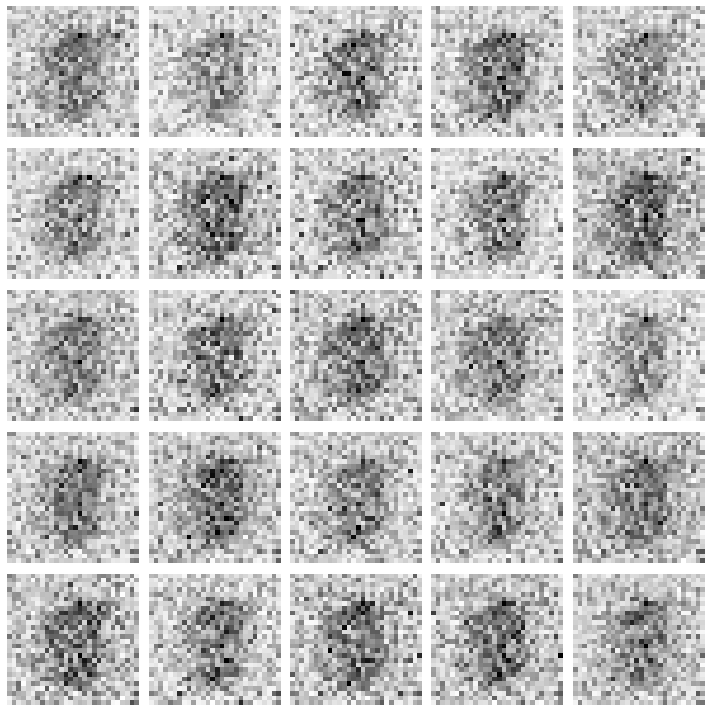

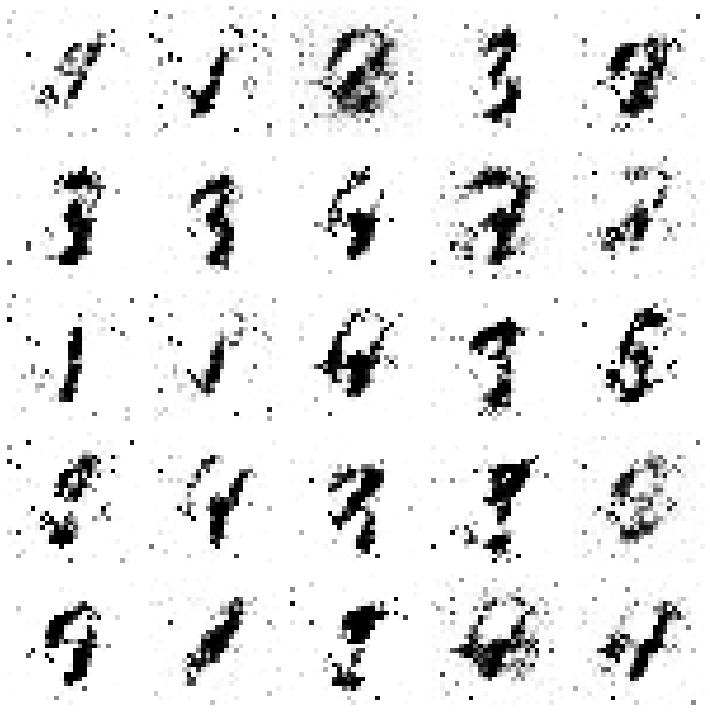

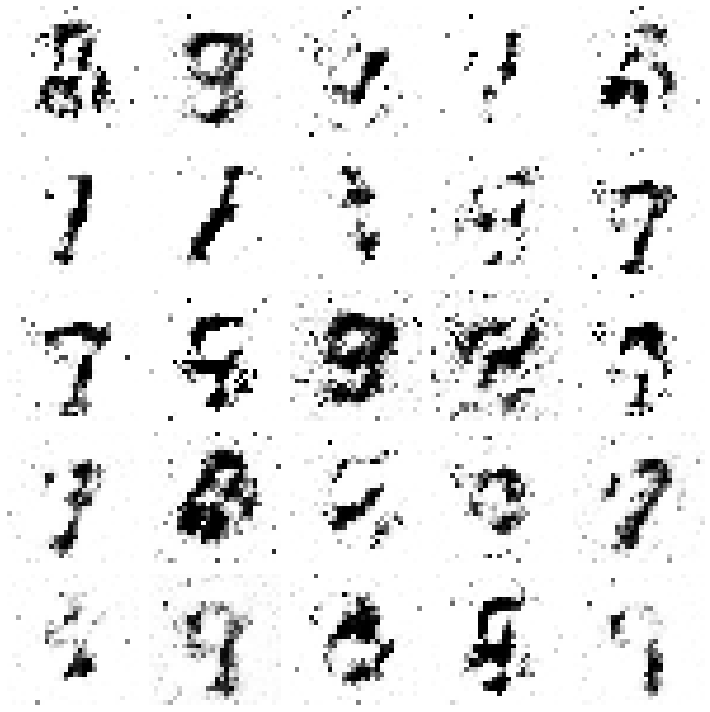

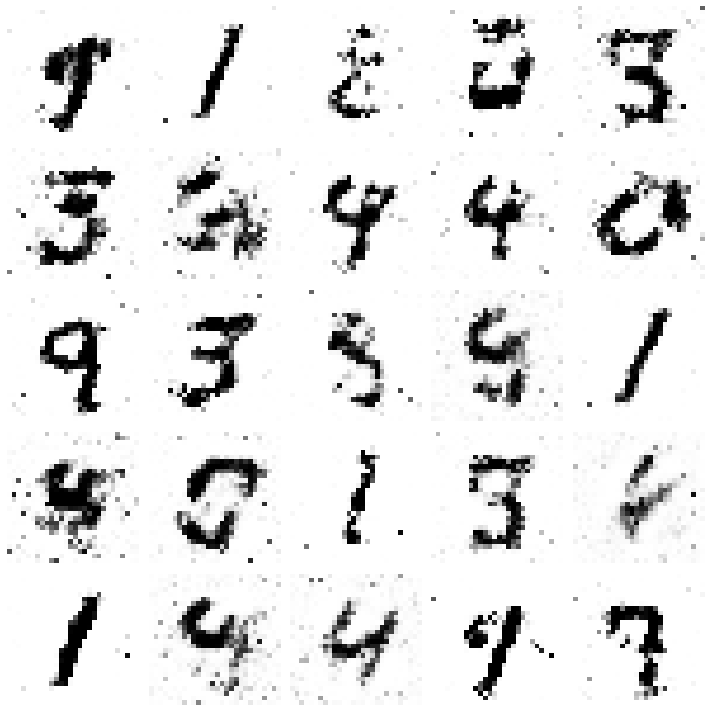

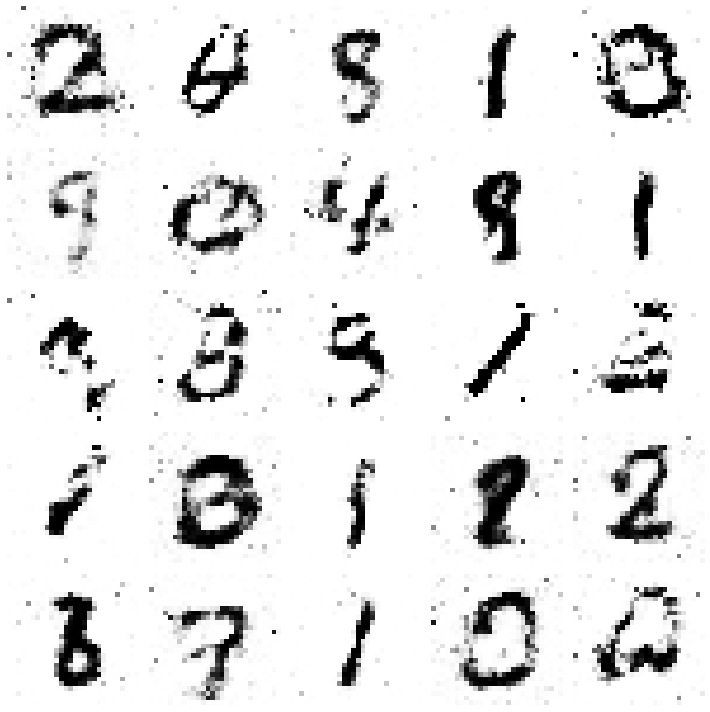

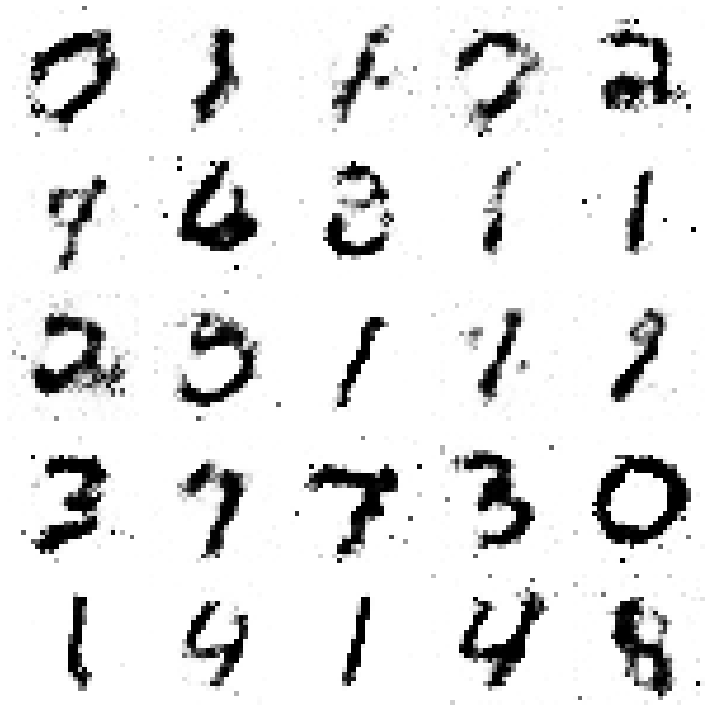

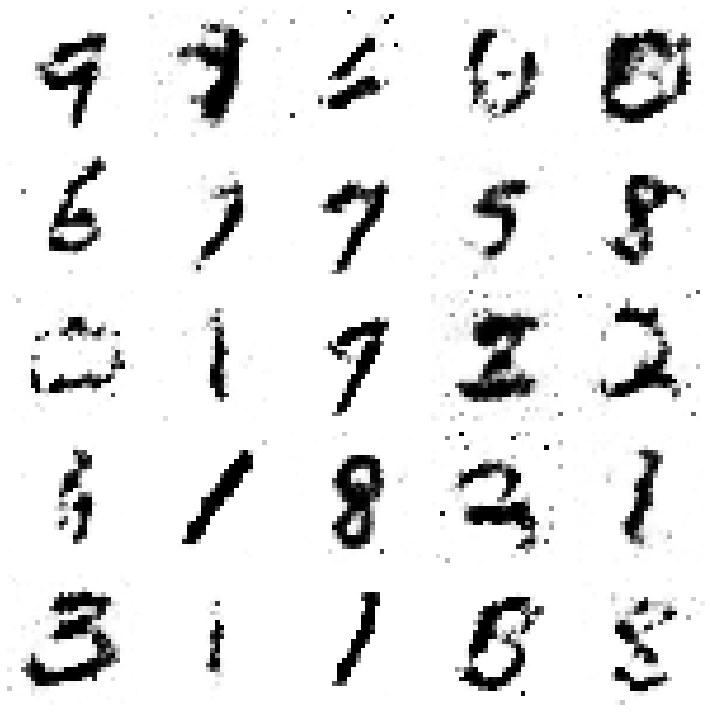

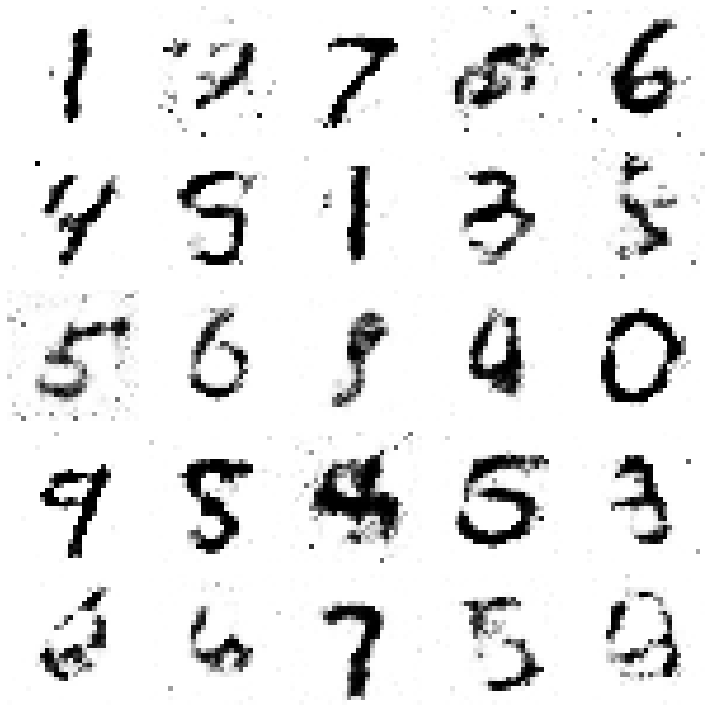

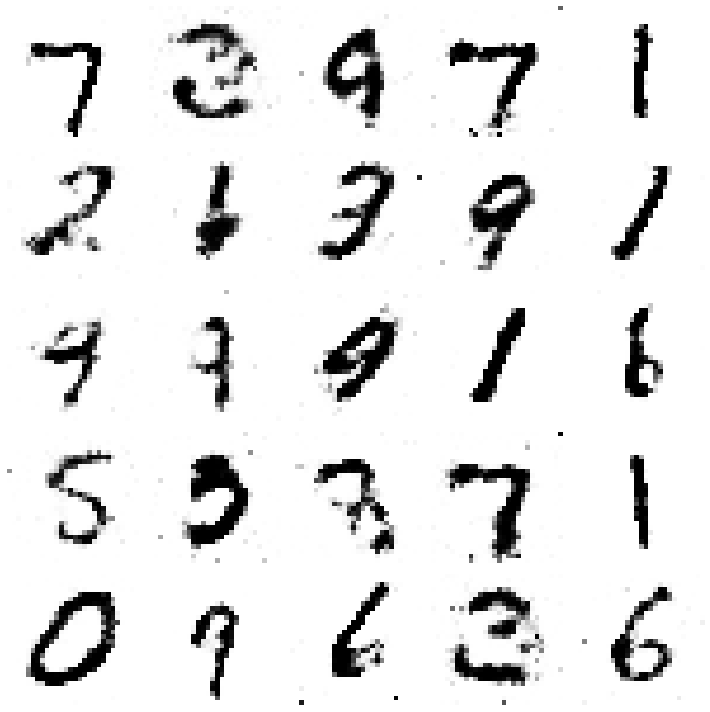

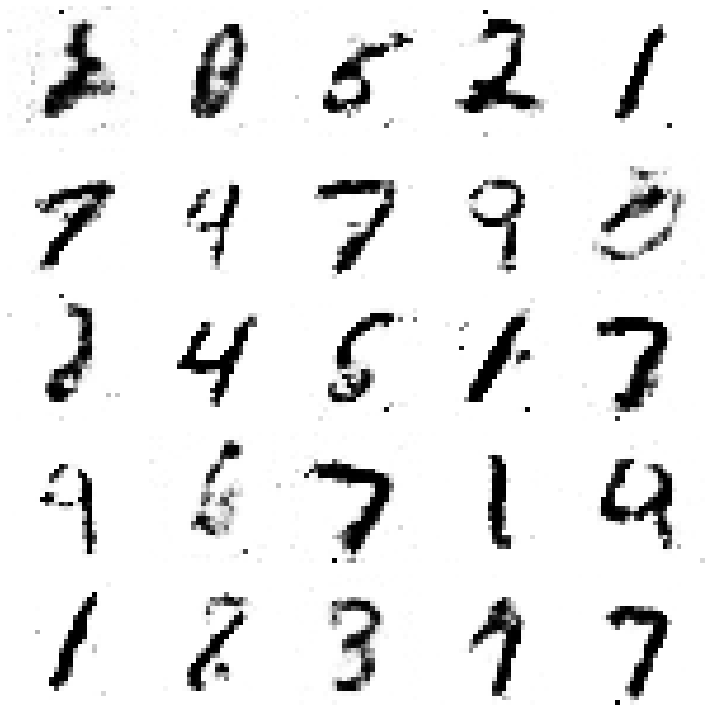

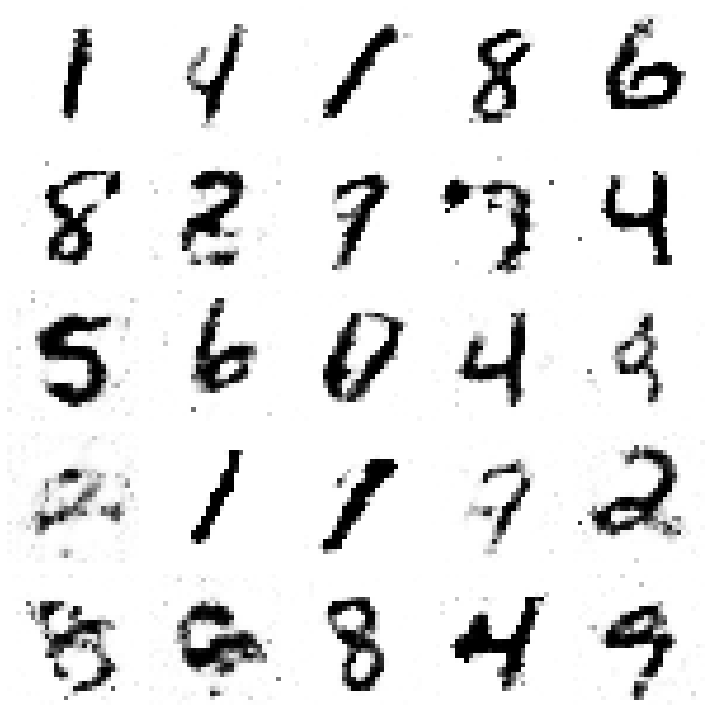

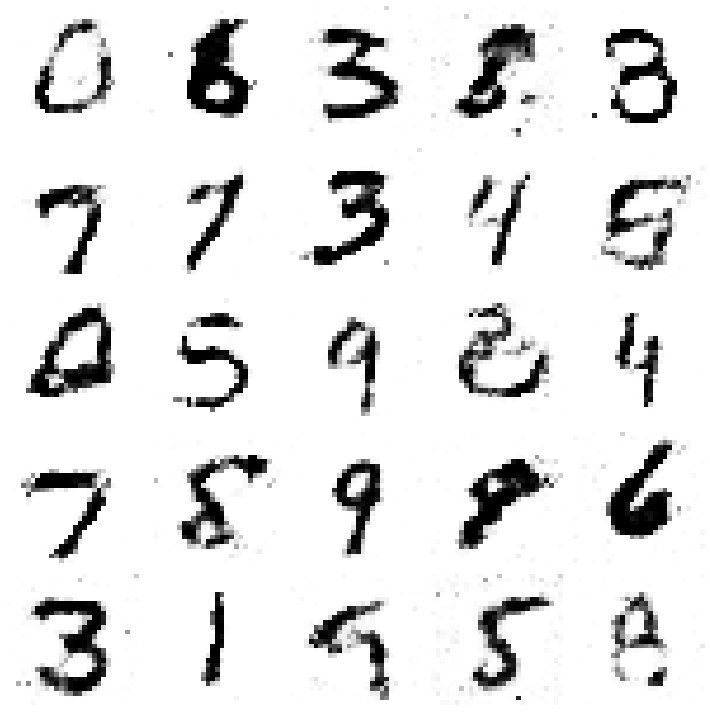

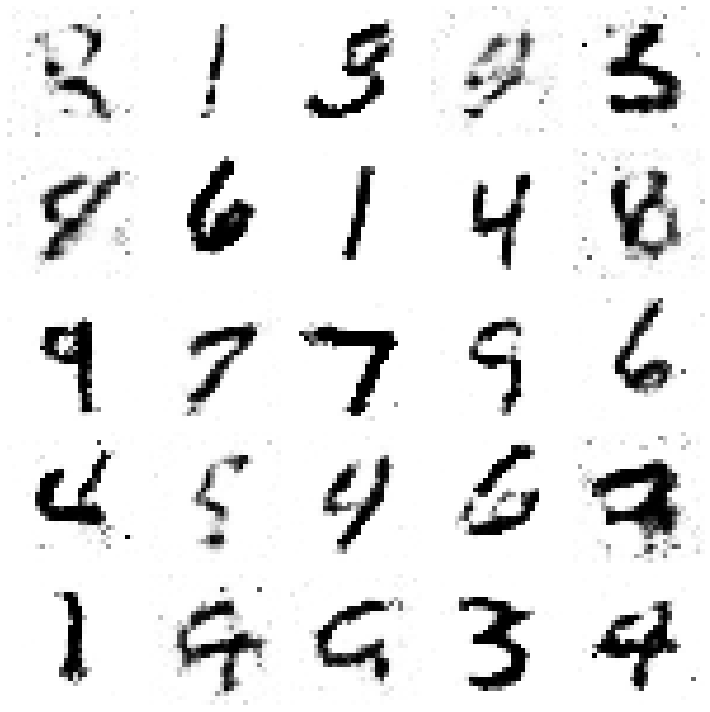

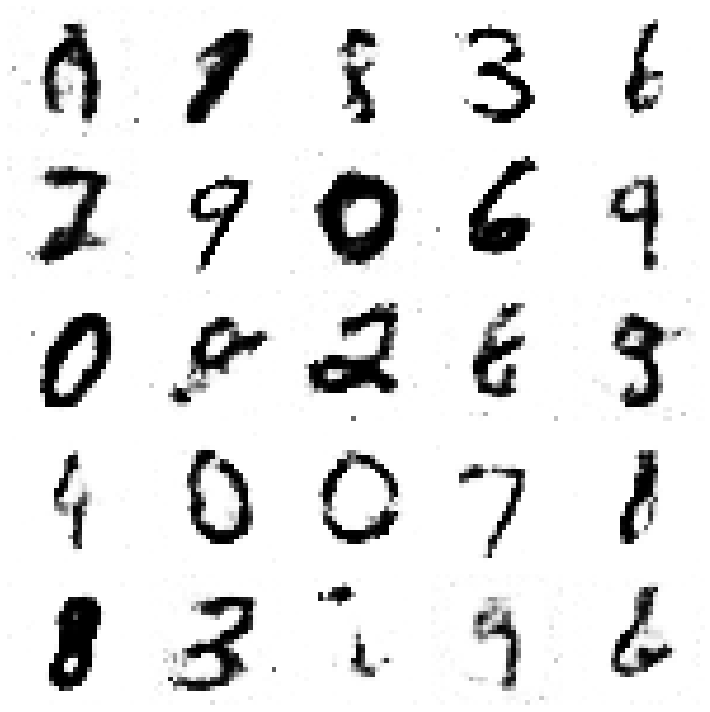

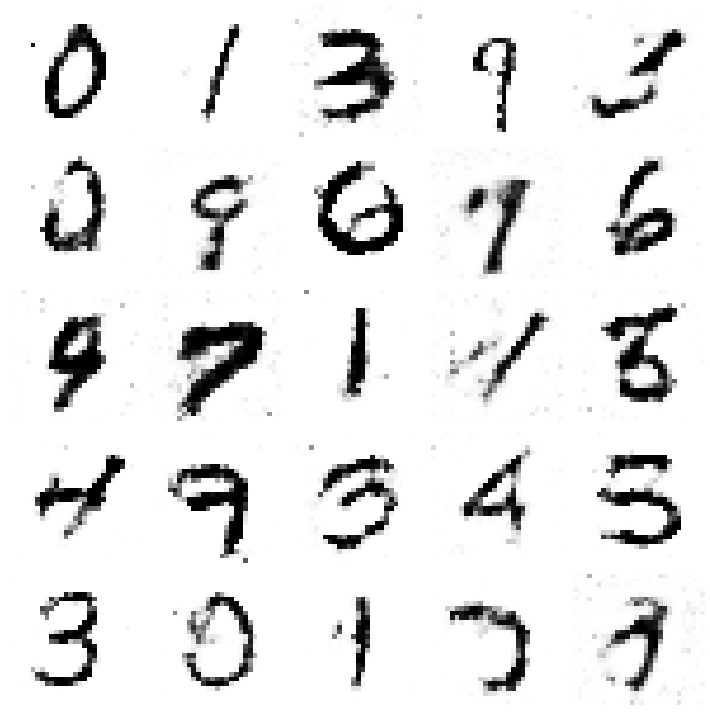

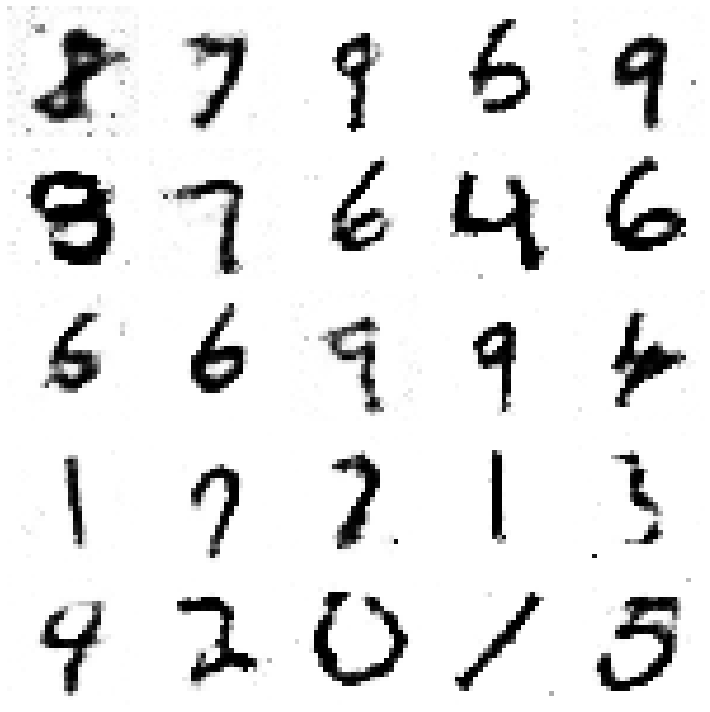

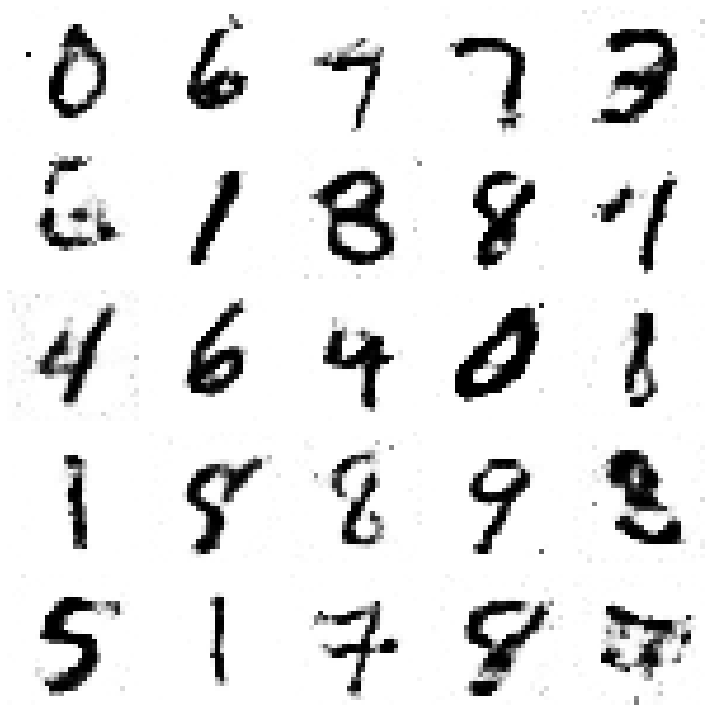

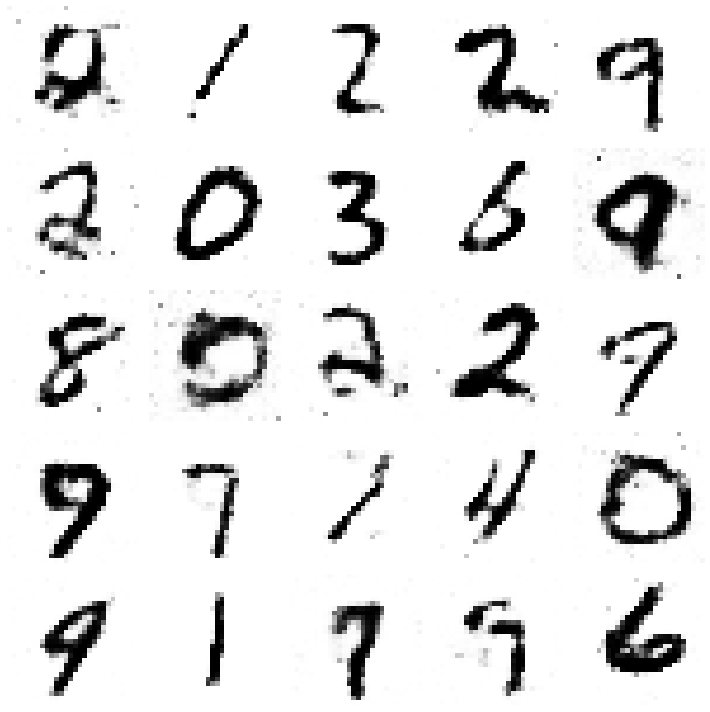

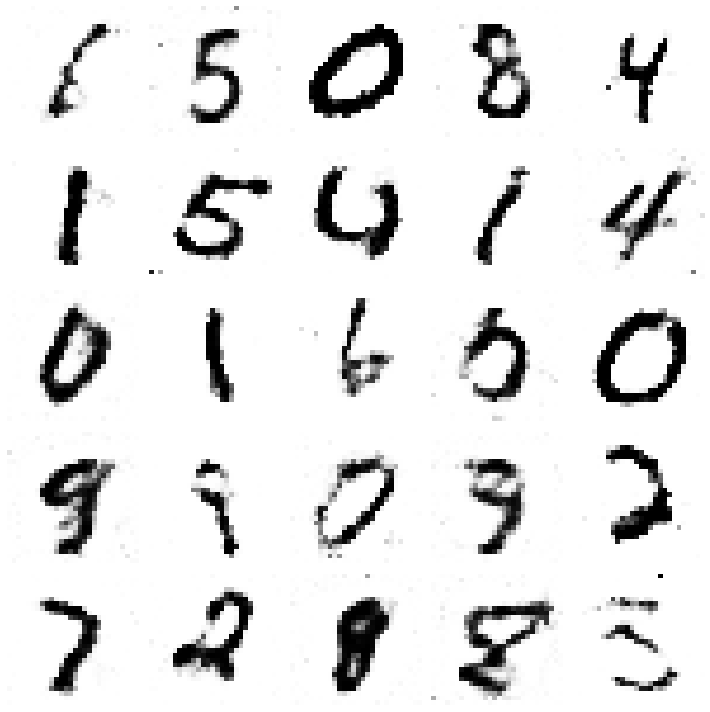

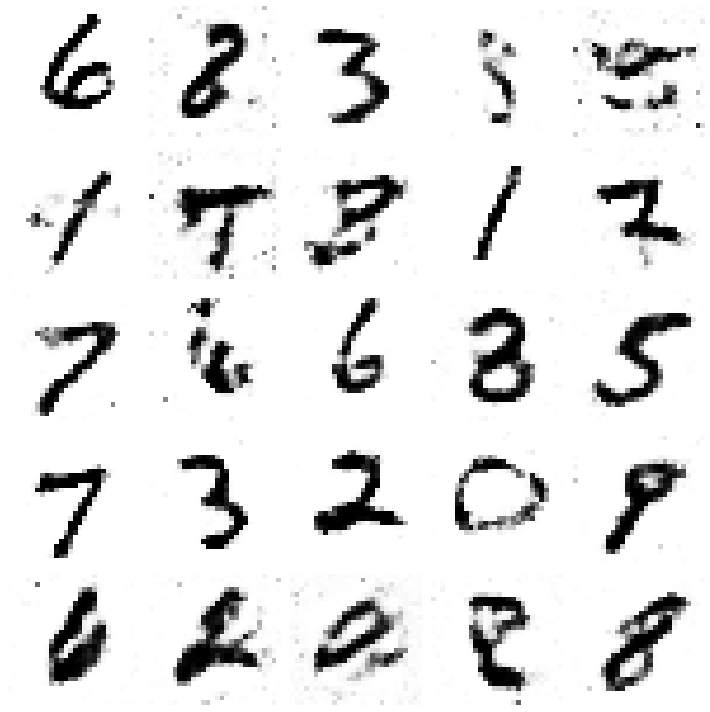

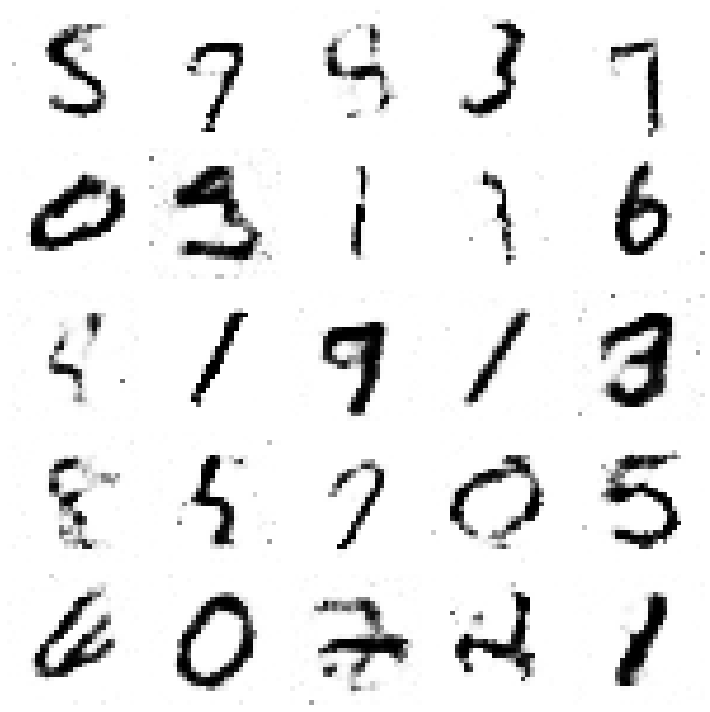

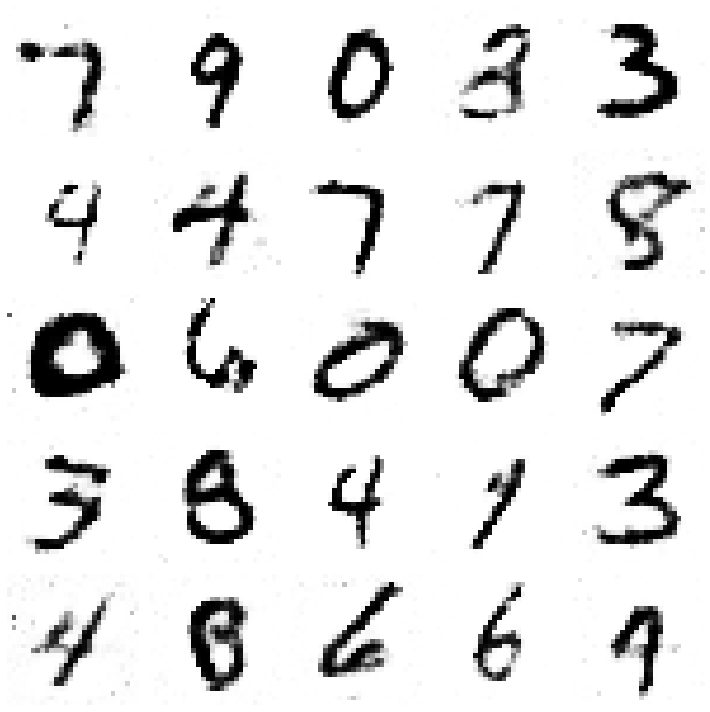

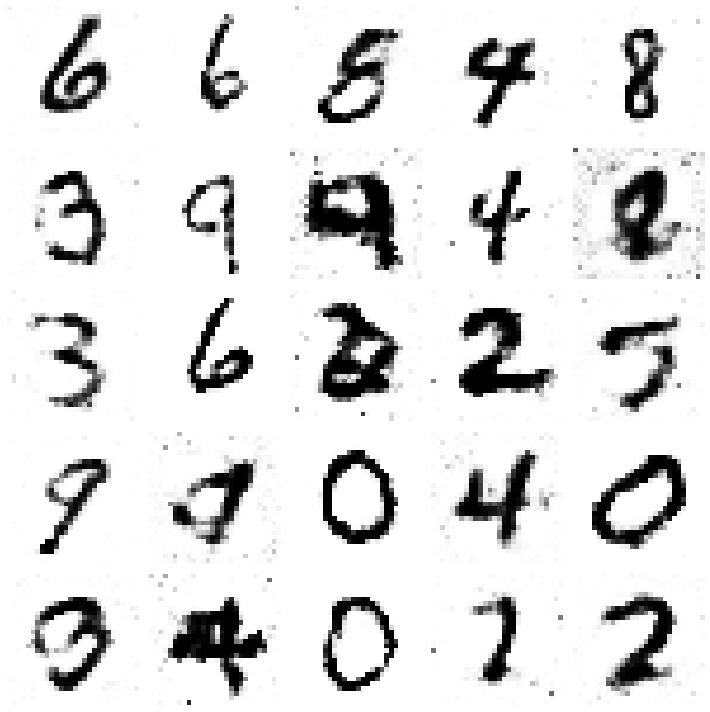

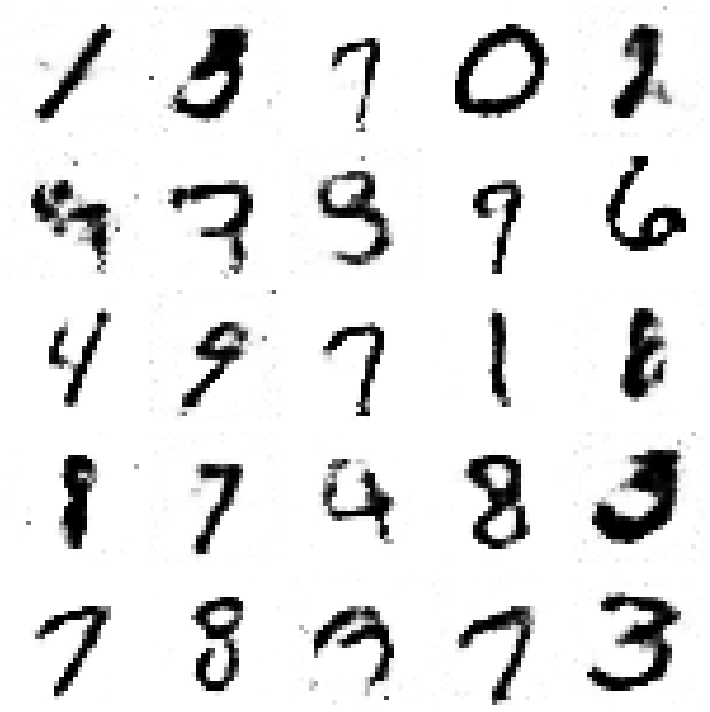

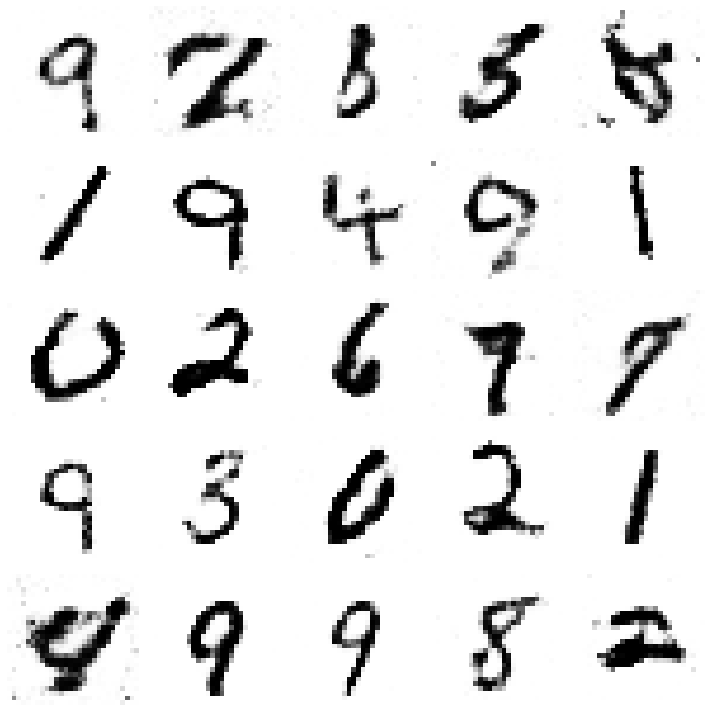

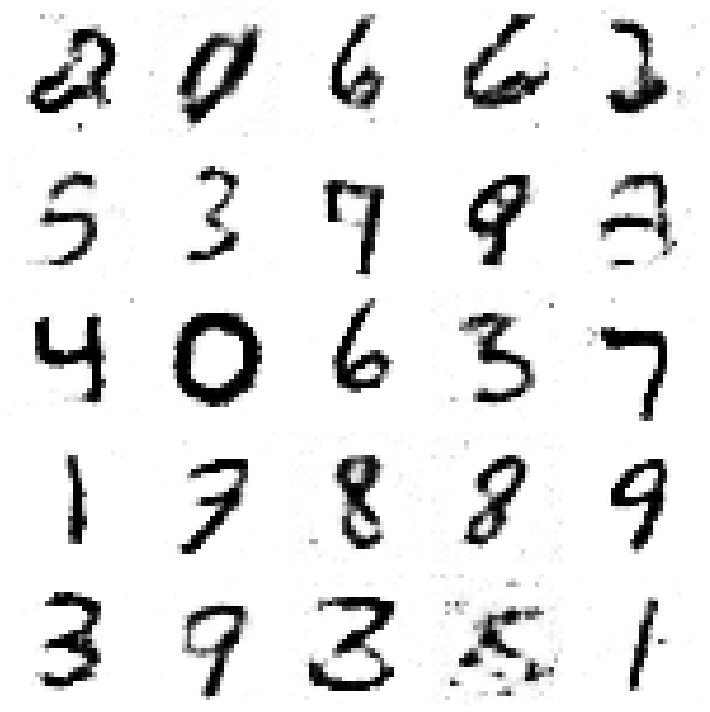

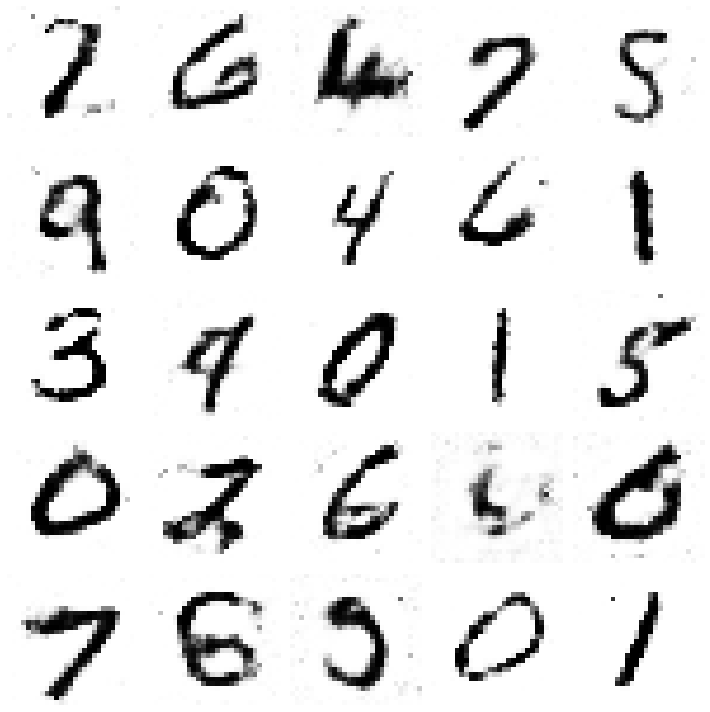

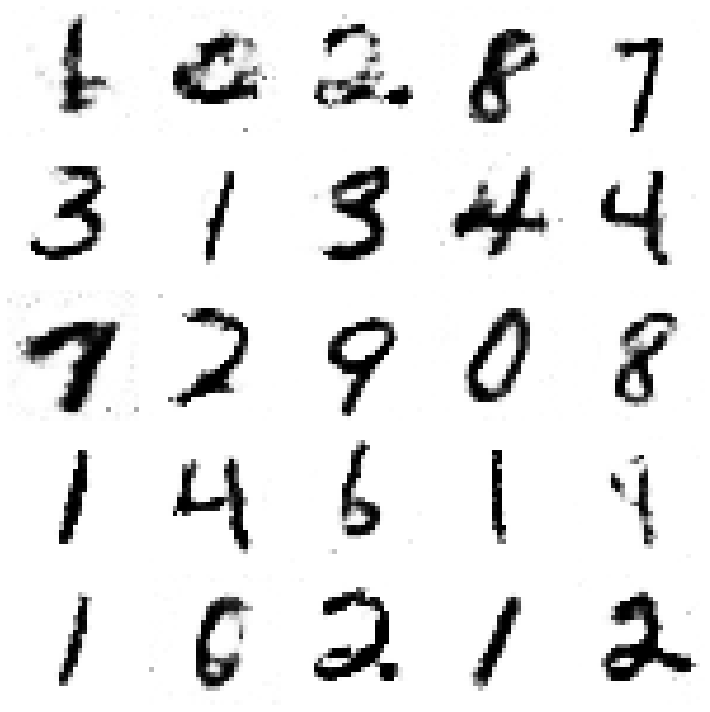

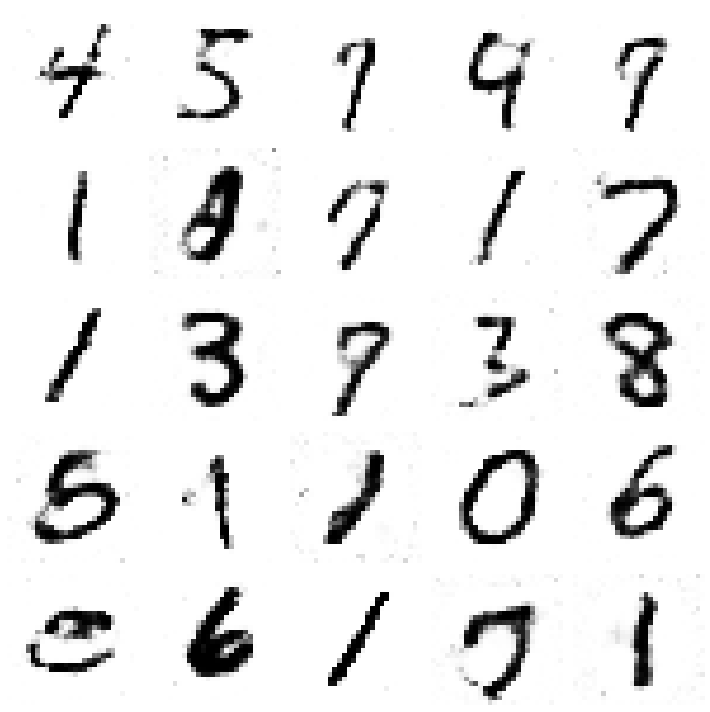

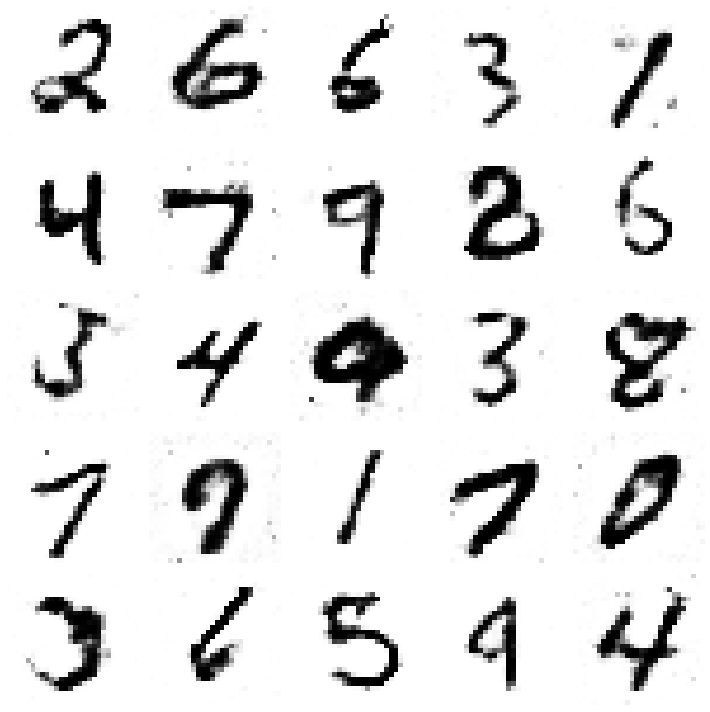

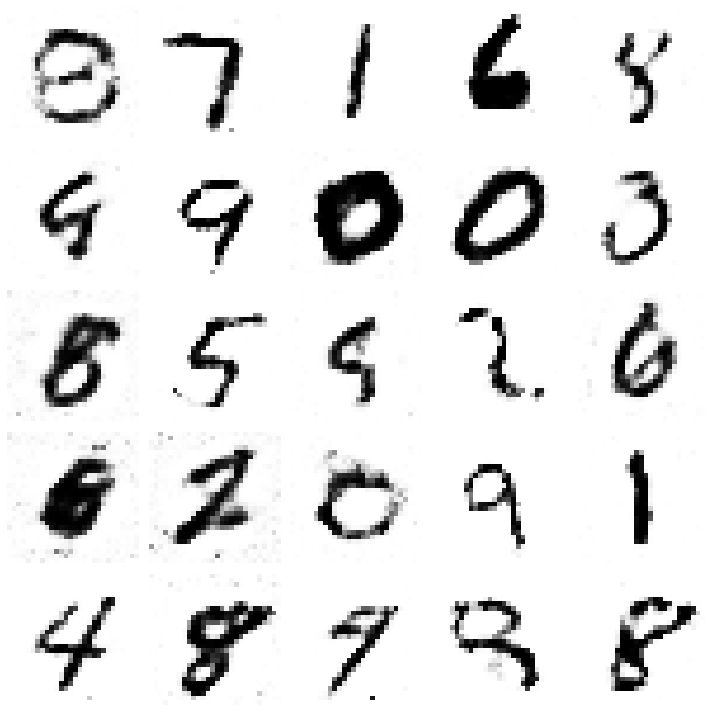

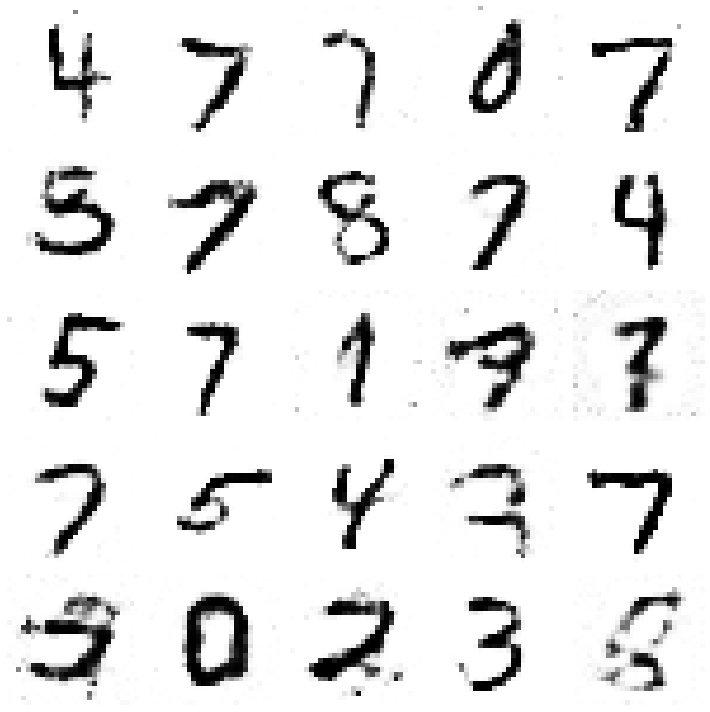

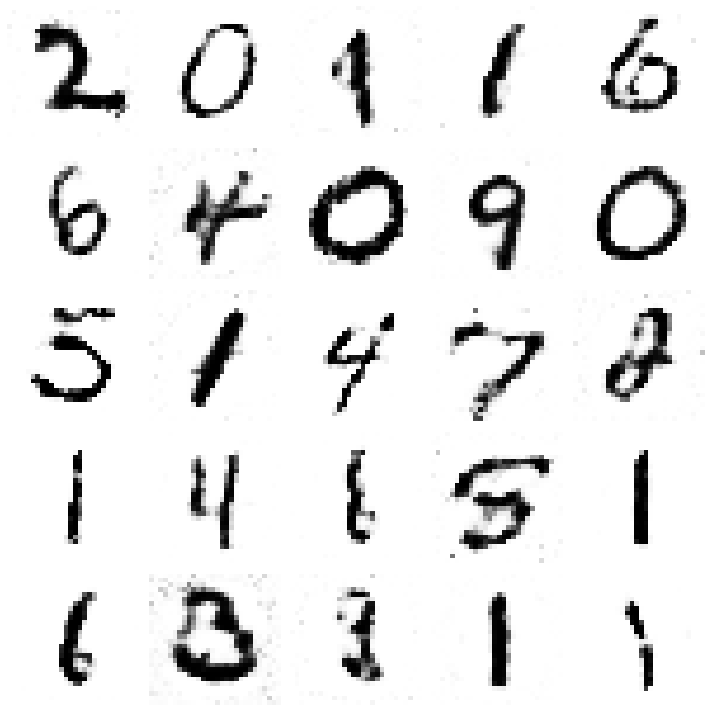

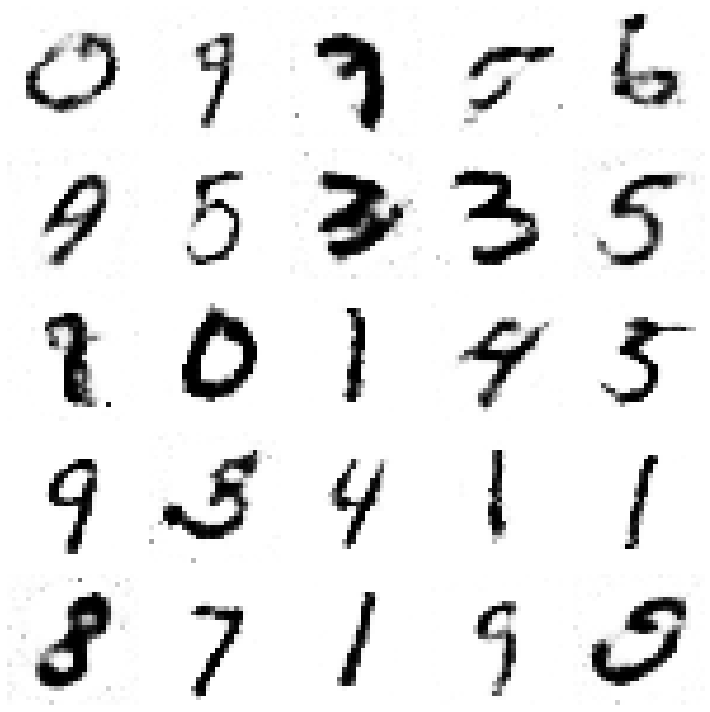

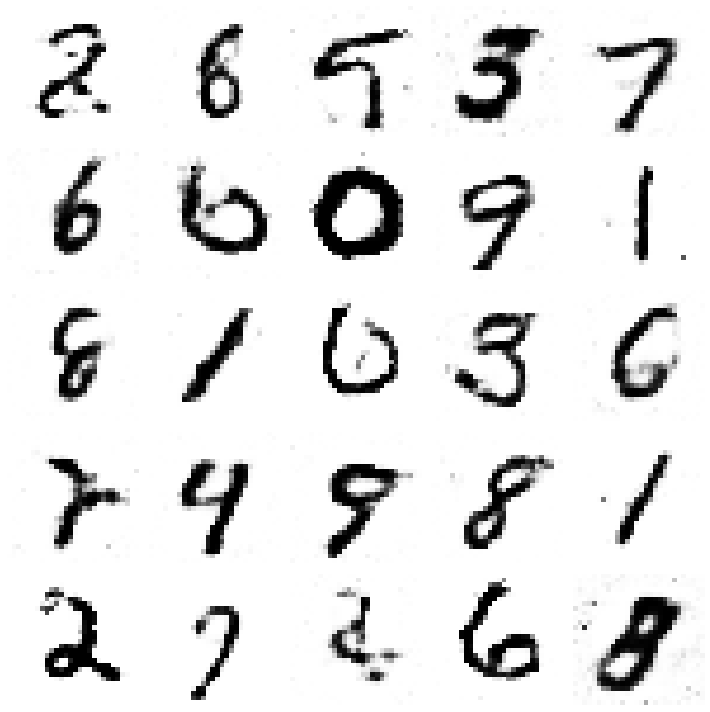

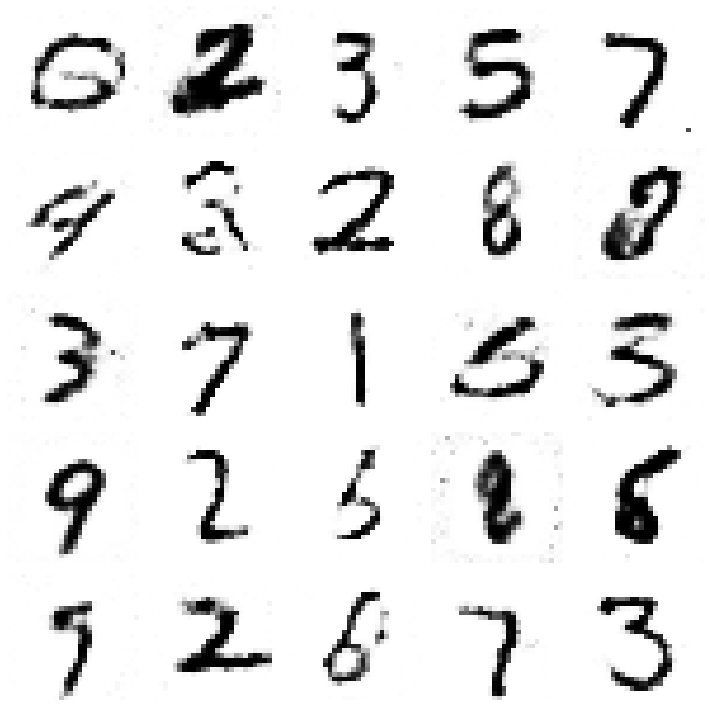

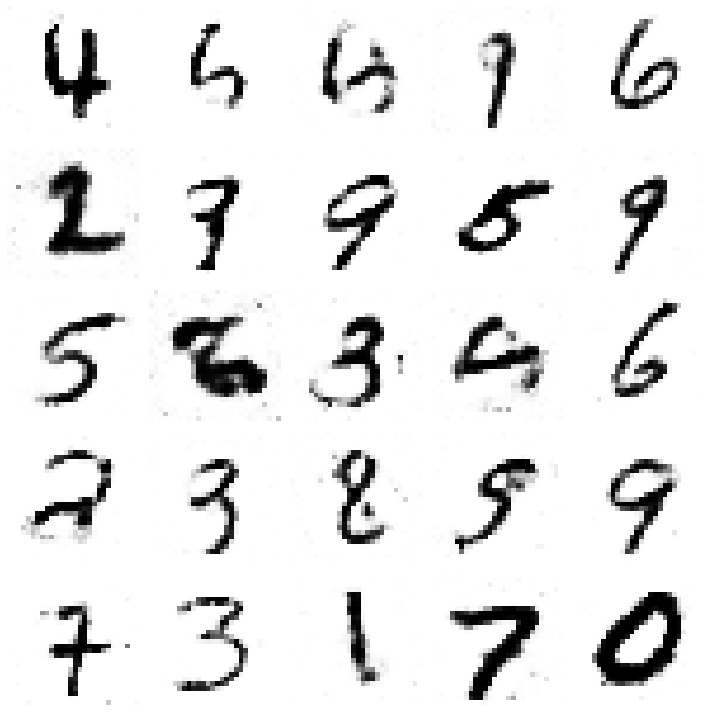

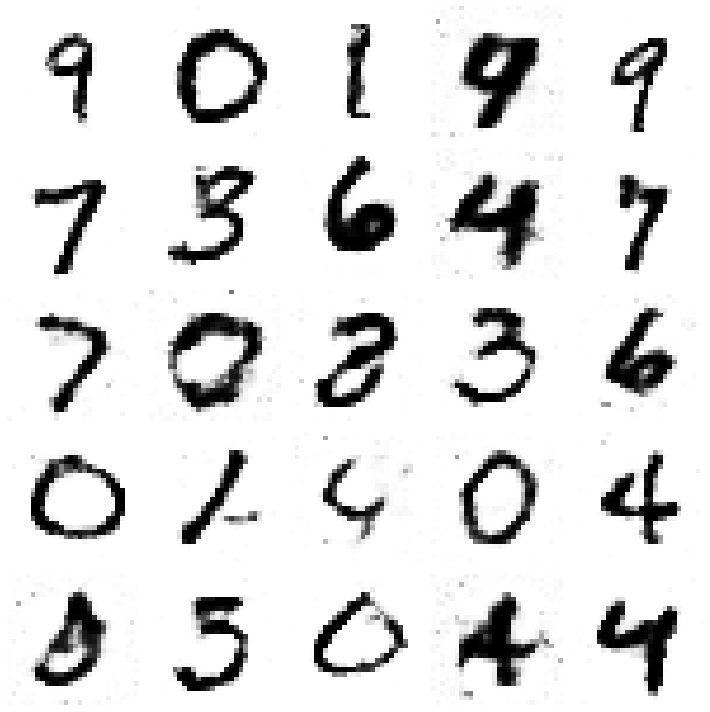

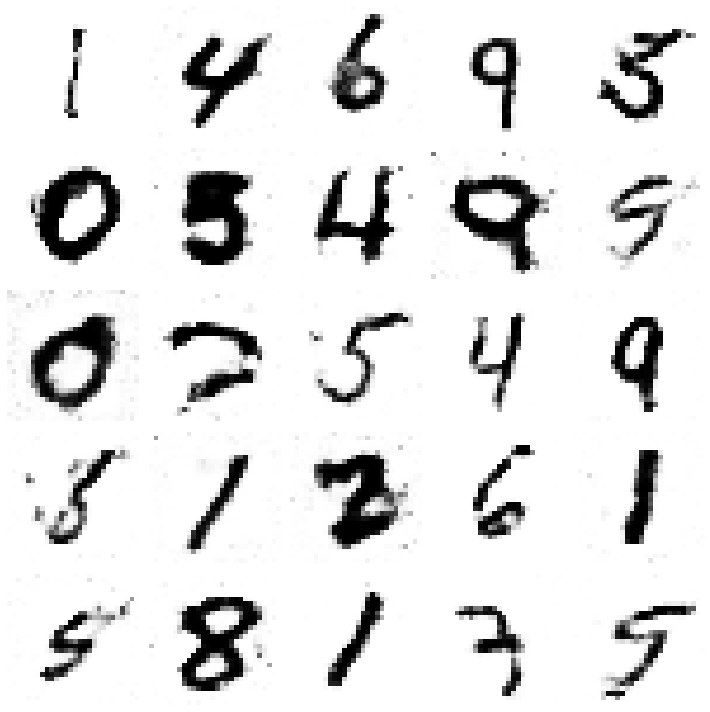

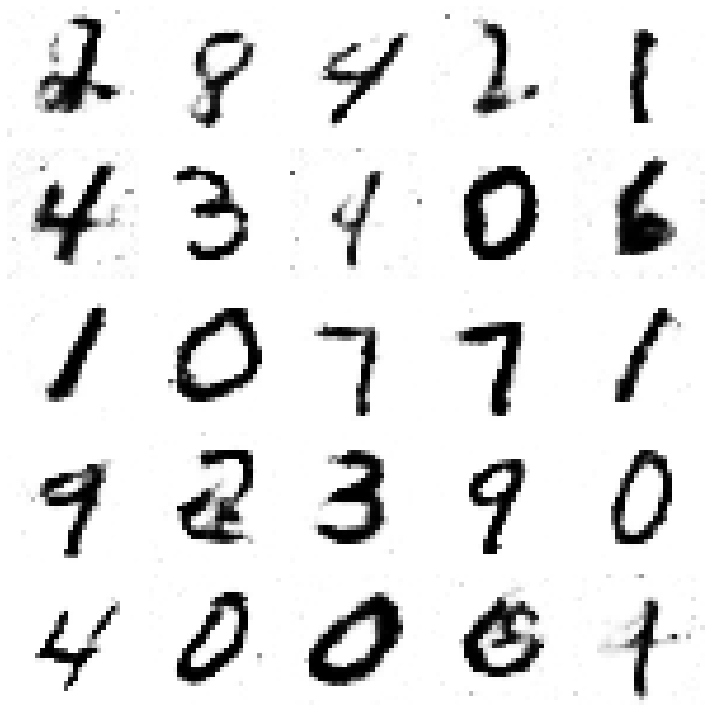

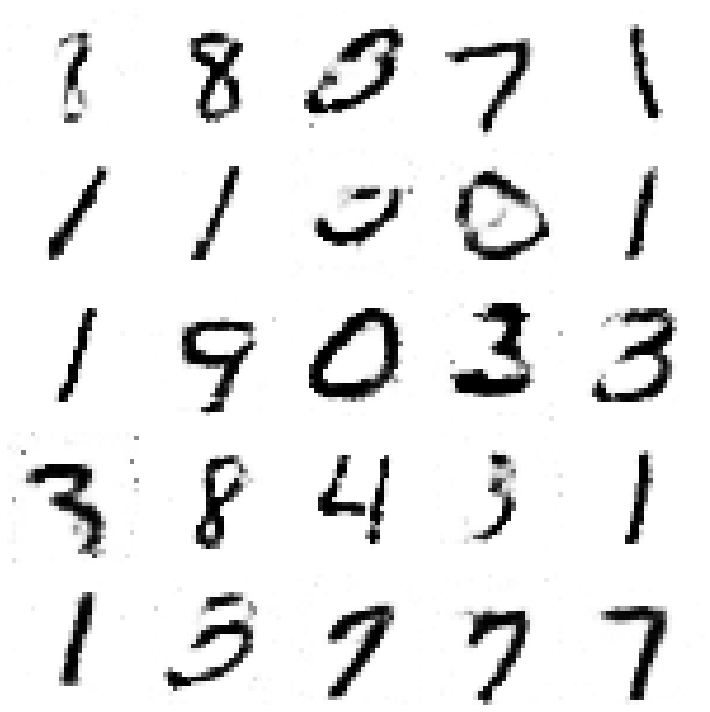

In [16]:
train_GAN(epochs=400, batch_size=128)